In [3]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph

# Parameters

In [4]:
iteration = 1
PhenoGraph_k =  30
PopulationGraph_type = 'complete_graph_with_weak_edges_removed'
para_dict = {
    'weight_threshold_percentile': 90,
    'knn_k':10
}

# Load data

##### pattern feature and ids

In [5]:
FILE_NAMES = os.listdir(
    os.path.join(PROJECT_ROOT, "Output", "b_Soft_WL_Kernel", "Danenberg", "Cohort_1", 'Subtrees')
)
X = []
Cluster_identities = []
Indices = []
for i in range(len(FILE_NAMES)):
    file_name = FILE_NAMES[i]
    x = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "Subtrees",
            file_name,
            "neighborhood_aggregation",
            "X" + str(iteration) + ".npy",
        )
    )
    cluster_identities = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "Subtrees",
            file_name,
            "pattern_ids",
            "pattern_id_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".npy",
        )
    )
    indices = np.zeros(x.shape[0], dtype=int)
    indices[:] = i

    Indices.append(indices)
    X.append(x)
    Cluster_identities.append(cluster_identities)
X = np.concatenate(X, axis=0)
Cluster_identities = np.concatenate(Cluster_identities, axis=0)
Indices = np.concatenate(Indices, axis=0)

#### Gram matrix

In [6]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]

G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)


#### Clinical

In [7]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical.head()
ER_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'ER Status'].values[0] for patient_id in Patient_IDs])
PR_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs])
HER2_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs])
Clinical_subtype = np.zeros(ER_status.shape, dtype=object)
for i in range(len(ER_status)):
    er= ER_status[i]
    pr= PR_status[i]
    her2= HER2_status[i]
    if (er == 'Positive' or pr == 'Positive') and her2 == 'Negative':
        Clinical_subtype[i] = 'HR+/HER2-'
    elif (er == 'Positive' or pr == 'Positive') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR+/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Positive':
        Clinical_subtype[i] = 'HR-/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Negative':
        Clinical_subtype[i] = 'TNBC'
print("{} patients in total, {} HR+/HER2-, {} HR+/HER2+, {} HR-/HER2+, {} TNBC".format(len(Clinical_subtype),
np.sum(Clinical_subtype == 'HR+/HER2-'), np.sum(Clinical_subtype == 'HR+/HER2+'), np.sum(Clinical_subtype == 'HR-/HER2+'), np.sum(Clinical_subtype == 'TNBC')))


425 patients in total, 270 HR+/HER2-, 23 HR+/HER2+, 17 HR-/HER2+, 59 TNBC


In [8]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])

# Population Graph

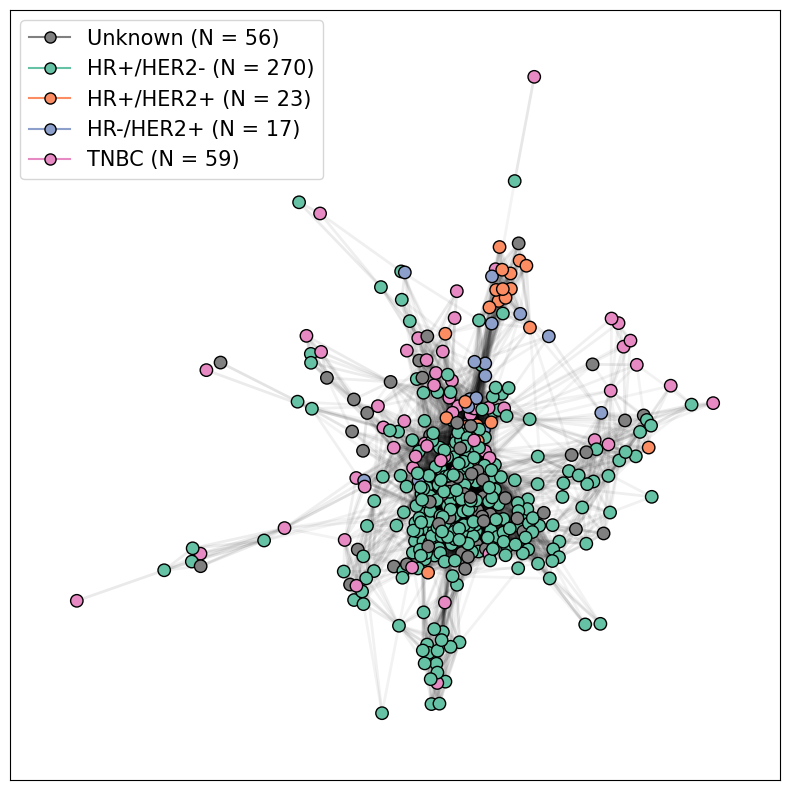

In [9]:
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
    0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0
    for u, v in edge_list
]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
color_palette = ['grey'] + sns.color_palette("Set2")
Clinical_subtype_id = np.array([0] * len(Clinical_subtype))
Clinical_subtype_id[Clinical_subtype == "HR+/HER2-"] = 1
Clinical_subtype_id[Clinical_subtype == "HR+/HER2+"] = 2
Clinical_subtype_id[Clinical_subtype == "HR-/HER2+"] = 3
Clinical_subtype_id[Clinical_subtype == "TNBC"] = 4
nx.draw_networkx_nodes(
    G_population, pos, node_size=80, node_color=[color_palette[i] for i in Clinical_subtype_id], edgecolors="black"
)
handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="grey",
        label="Unknown (N = {})".format(np.sum(Clinical_subtype_id == 0)),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[1],
        label="HR+/HER2- (N = {})".format(np.sum(Clinical_subtype == "HR+/HER2-")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[2],
        label="HR+/HER2+ (N = {})".format(np.sum(Clinical_subtype == "HR+/HER2+")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[3],
        label="HR-/HER2+ (N = {})".format(np.sum(Clinical_subtype == "HR-/HER2+")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
        Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[4],
        label="TNBC (N = {})".format(np.sum(Clinical_subtype == "TNBC")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),



]
ax.legend(handles=handles, fontsize = 15)
plt.show()

In [10]:
Gram_matrix_ = Gram_matrix[np.array(np.where(Clinical_subtype == 'TNBC')[0].tolist()), :][:, np.array(np.where(Clinical_subtype == 'TNBC')[0].tolist())]
print("{} TNBC patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
Gram_matrix_ = Gram_matrix[np.array(np.where(Clinical_subtype == 'HR+/HER2-')[0].tolist()), :][:, np.array(np.where(Clinical_subtype == 'HR+/HER2-')[0].tolist())]
print("{} 'HR+/HER2-' patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
Gram_matrix_ = Gram_matrix[np.array(np.where(Clinical_subtype == 'HR+/HER2+')[0].tolist()), :][:, np.array(np.where(Clinical_subtype == 'HR+/HER2+')[0].tolist())]
print("{} 'HR+/HER2+' patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
Gram_matrix_ = Gram_matrix[np.array(np.where(Clinical_subtype == 'HR-/HER2+')[0].tolist()), :][:, np.array(np.where(Clinical_subtype == 'HR-/HER2+')[0].tolist())]
print("{} 'HR-/HER2+' patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
print("{} Overall patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))

59 TNBC patients, averaged Intra-group similarity is 0.14 
270 'HR+/HER2-' patients, averaged Intra-group similarity is 0.20 
23 'HR+/HER2+' patients, averaged Intra-group similarity is 0.32 
17 'HR-/HER2+' patients, averaged Intra-group similarity is 0.33 
425 Overall patients, averaged Intra-group similarity is 0.18 


# K-M Plot

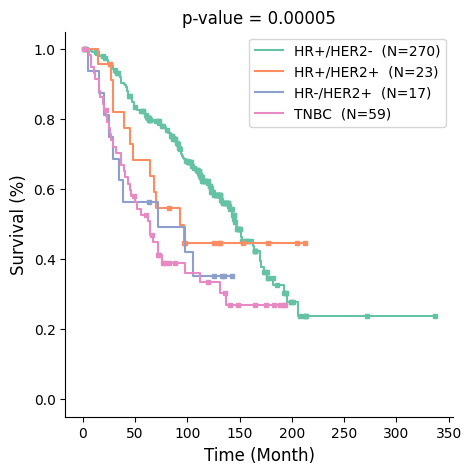

In [21]:
color_palette = sns.color_palette("Set2")
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
Length = np.array([clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs])
Status = np.array([clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs])

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
# length_0, event_observed_0 = (
#             Length[Clinical_subtype_id == 0],
#             Status[Clinical_subtype_id == 0],
# )
# print(length_0, event_observed_0)
# label = "Unknown(N={})".format( len(length_0))
# kmf.fit(length_0, event_observed_0, label=label)
# kmf.plot_survival_function(ax=ax, ci_show=False, color='grey',show_censors=True,censor_styles={"ms": 3, "marker": "s"})

length_A, event_observed_A = (
            Length[Clinical_subtype == 'HR+/HER2-'],
            Status[Clinical_subtype == 'HR+/HER2-'],
        )
label = "HR+/HER2-  (N={})".format( len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[0],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length[Clinical_subtype == 'HR+/HER2+'],
            Status[Clinical_subtype == 'HR+/HER2+'],
        )
label = "HR+/HER2+  (N={})".format( len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[1],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

length_C, event_observed_C = (
            Length[Clinical_subtype == 'HR-/HER2+'],
            Status[Clinical_subtype == 'HR-/HER2+'],
        )
label = "HR-/HER2+  (N={})".format( len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[2],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

length_D, event_observed_D = (

            Length[Clinical_subtype == 'TNBC'],
            Status[Clinical_subtype == 'TNBC'],
        )   
label = "TNBC  (N={})".format( len(length_D))
kmf.fit(length_D, event_observed_D, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[3],show_censors=True,censor_styles={"ms": 3, "marker": "s"})

log_rank_test = multivariate_logrank_test(
    np.concatenate([length_A, length_B, length_C, length_D]),
    [0]*len(length_A) + [1]*len(length_B) + [2]*len(length_C) + [3]*len(length_D),
    np.concatenate([event_observed_A, event_observed_B, event_observed_C, event_observed_D]),
)
p_value = log_rank_test.p_value
ax.legend(fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

# TNBC

### Over/Under-presented patterns

In [64]:
from scipy import stats
Histogram_pos = Histograms[Clinical_subtype == 'TNBC']
Histogram_neg = Histograms[Clinical_subtype != 'TNBC']
Overpresented_in_pos = []
Overpresented_in_neg = []
for i in range(Histograms.shape[1]):
    rvsi = Histogram_pos[:, i]
    rvso = Histogram_neg[:, i]
    result = stats.ttest_ind(rvsi, rvso, equal_var=False)
    if result.pvalue < 0.05 / Histograms.shape[1]:
        print("Pattern {}, Mean in pos = {:.0f}, Mean in neg = {:.0f} (p={:.5f})".format(i, np.mean(rvsi), np.mean(rvso), result.pvalue))
        if np.mean(rvsi) > np.mean(rvso):
            Overpresented_in_pos.append(i)
        else:
            Overpresented_in_neg.append(i)
if len(Overpresented_in_pos) == 0:
    print("No pattern is overpresented in TNBC patients")
else:
    print("Overpresented patterns in TNBC patients are {}".format(Overpresented_in_pos))
if len(Overpresented_in_neg) == 0:
    print("No pattern is underpresented in TNBC patients")
else:
    print("Underpresented patterns in TNBC patients are {}".format(Overpresented_in_neg))


Pattern 6, Mean in pos = 4, Mean in neg = 73 (p=0.00000)
Pattern 7, Mean in pos = 6, Mean in neg = 70 (p=0.00000)
Pattern 15, Mean in pos = 8, Mean in neg = 54 (p=0.00000)
Pattern 21, Mean in pos = 0, Mean in neg = 40 (p=0.00000)
Pattern 25, Mean in pos = 5, Mean in neg = 36 (p=0.00000)
Pattern 26, Mean in pos = 4, Mean in neg = 32 (p=0.00000)
Pattern 27, Mean in pos = 4, Mean in neg = 31 (p=0.00000)
Pattern 28, Mean in pos = 8, Mean in neg = 30 (p=0.00000)
Pattern 31, Mean in pos = 1, Mean in neg = 28 (p=0.00000)
Pattern 35, Mean in pos = 0, Mean in neg = 19 (p=0.00000)
Pattern 38, Mean in pos = 0, Mean in neg = 18 (p=0.00066)
No pattern is overpresented in TNBC patients
Underpresented patterns in TNBC patients are [6, 7, 15, 21, 25, 26, 27, 28, 31, 35, 38]


(64, 32)


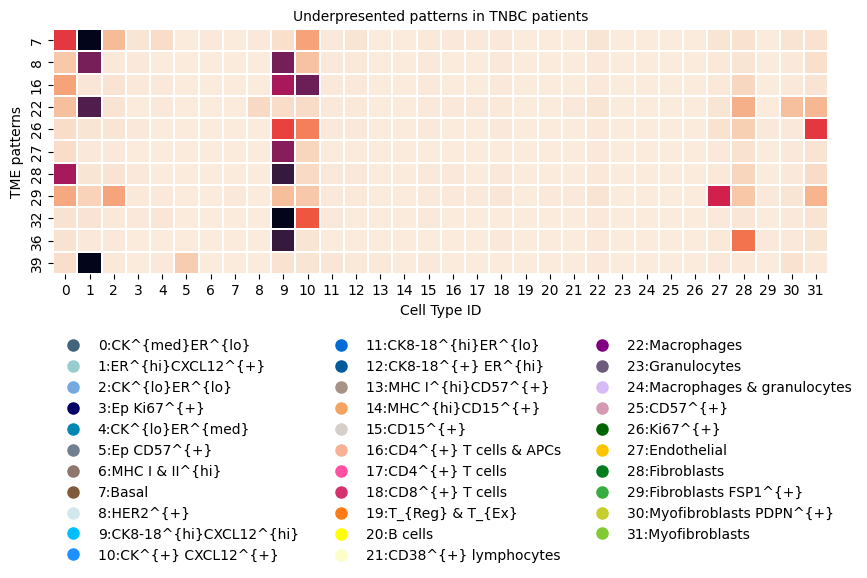

In [65]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
Centroids = compute_cluster_centroids(X, Cluster_identities)
print(Centroids.shape)
if len(Overpresented_in_pos) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7),  gridspec_kw= {"height_ratios": [1,1]})
    sns.heatmap(
                Centroids[Overpresented_in_pos, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_pos], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Overpresented patterns in TNBC patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()
if len(Overpresented_in_neg) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7),  gridspec_kw= {"height_ratios": [1,1]})
    sns.heatmap(
                Centroids[Overpresented_in_neg, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_neg], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Underpresented patterns in TNBC patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()

# HR+/HER2-

### Over-presented patterns

In [66]:
from scipy import stats
Histogram_pos = Histograms[Clinical_subtype == 'HR+/HER2-']
Histogram_neg = Histograms[Clinical_subtype != 'HR+/HER2-']
Overpresented_in_pos = []
Overpresented_in_neg = []
for i in range(Histograms.shape[1]):
    rvsi = Histogram_pos[:, i]
    rvso = Histogram_neg[:, i]
    result = stats.ttest_ind(rvsi, rvso, equal_var=False)
    if result.pvalue < 0.05 / Histograms.shape[1]:
        print("Pattern {}, Mean in pos = {:.0f}, Mean in neg = {:.0f} (p={:.5f})".format(i, np.mean(rvsi), np.mean(rvso), result.pvalue))
        if np.mean(rvsi) > np.mean(rvso):
            Overpresented_in_pos.append(i)
        else:
            Overpresented_in_neg.append(i)
if len(Overpresented_in_pos) == 0:
    print("No pattern is overpresented in HR+/HER2- patients")
if len(Overpresented_in_neg) == 0:
    print("No pattern is underpresented in HR+/HER2- patients")


Pattern 2, Mean in pos = 104, Mean in neg = 29 (p=0.00000)
Pattern 4, Mean in pos = 101, Mean in neg = 16 (p=0.00005)
Pattern 6, Mean in pos = 88, Mean in neg = 20 (p=0.00000)
Pattern 7, Mean in pos = 80, Mean in neg = 28 (p=0.00002)
Pattern 15, Mean in pos = 68, Mean in neg = 13 (p=0.00000)
Pattern 22, Mean in pos = 7, Mean in neg = 82 (p=0.00025)
Pattern 25, Mean in pos = 41, Mean in neg = 16 (p=0.00020)
Pattern 26, Mean in pos = 38, Mean in neg = 10 (p=0.00001)
Pattern 28, Mean in pos = 34, Mean in neg = 15 (p=0.00000)
Pattern 31, Mean in pos = 35, Mean in neg = 6 (p=0.00011)
Pattern 35, Mean in pos = 24, Mean in neg = 4 (p=0.00015)


(64, 32)


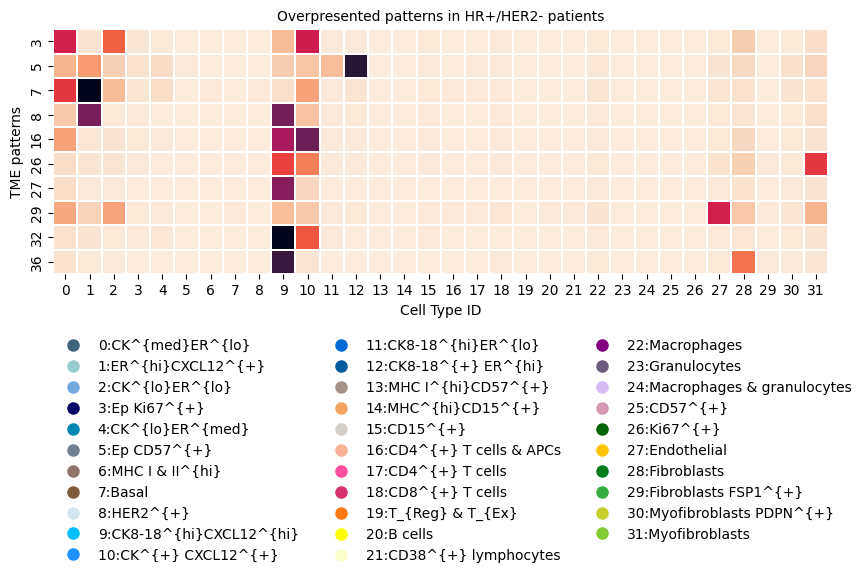

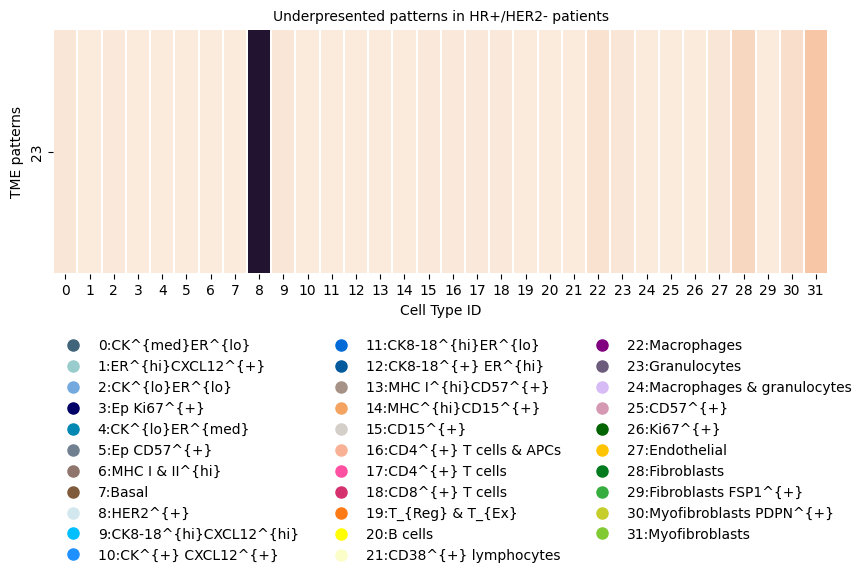

In [69]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
Centroids = compute_cluster_centroids(X, Cluster_identities)
print(Centroids.shape)
if len(Overpresented_in_pos) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7),  gridspec_kw= {"height_ratios": [1,1]})
    sns.heatmap(
                Centroids[Overpresented_in_pos, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_pos], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Overpresented patterns in HR+/HER2- patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()
if len(Overpresented_in_neg) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7),  gridspec_kw= {"height_ratios": [1,1]})
    sns.heatmap(
                Centroids[Overpresented_in_neg, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_neg], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Underpresented patterns in HR+/HER2- patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()

# HR-/HER2+

### Over-presented patterns

In [72]:
from scipy import stats
Histogram_pos = Histograms[Clinical_subtype == 'HR-/HER2+']
Histogram_neg = Histograms[Clinical_subtype != 'HR-/HER2+']
Overpresented_in_pos = []
Overpresented_in_neg = []
for i in range(Histograms.shape[1]):
    rvsi = Histogram_pos[:, i]
    rvso = Histogram_neg[:, i]
    result = stats.ttest_ind(rvsi, rvso, equal_var=False)
    if result.pvalue < 0.05 / Histograms.shape[1]:
        print("Pattern {}, Mean in pos = {:.0f}, Mean in neg = {:.0f} (p={:.5f})".format(i, np.mean(rvsi), np.mean(rvso), result.pvalue))
        if np.mean(rvsi) > np.mean(rvso):
            Overpresented_in_pos.append(i)
        else:
            Overpresented_in_neg.append(i)
if len(Overpresented_in_pos) == 0:
    print("No pattern is overpresented in HR-/HER2+ patients")
if len(Overpresented_in_neg) == 0:
    print("No pattern is underpresented in HR-/HER2+ patients")


Pattern 2, Mean in pos = 12, Mean in neg = 79 (p=0.00000)
Pattern 4, Mean in pos = 0, Mean in neg = 73 (p=0.00000)
Pattern 6, Mean in pos = 0, Mean in neg = 66 (p=0.00000)
Pattern 7, Mean in pos = 0, Mean in neg = 64 (p=0.00000)
Pattern 15, Mean in pos = 3, Mean in neg = 49 (p=0.00000)
Pattern 19, Mean in pos = 8, Mean in neg = 40 (p=0.00001)
Pattern 21, Mean in pos = 1, Mean in neg = 36 (p=0.00000)
Pattern 23, Mean in pos = 5, Mean in neg = 34 (p=0.00021)
Pattern 25, Mean in pos = 1, Mean in neg = 33 (p=0.00000)
Pattern 26, Mean in pos = 1, Mean in neg = 29 (p=0.00000)
Pattern 27, Mean in pos = 2, Mean in neg = 29 (p=0.00000)
Pattern 28, Mean in pos = 11, Mean in neg = 27 (p=0.00006)
Pattern 31, Mean in pos = 0, Mean in neg = 25 (p=0.00000)
Pattern 35, Mean in pos = 0, Mean in neg = 17 (p=0.00000)
Pattern 38, Mean in pos = 0, Mean in neg = 16 (p=0.00064)
No pattern is overpresented in HR-/HER2+ patients


(64, 32)


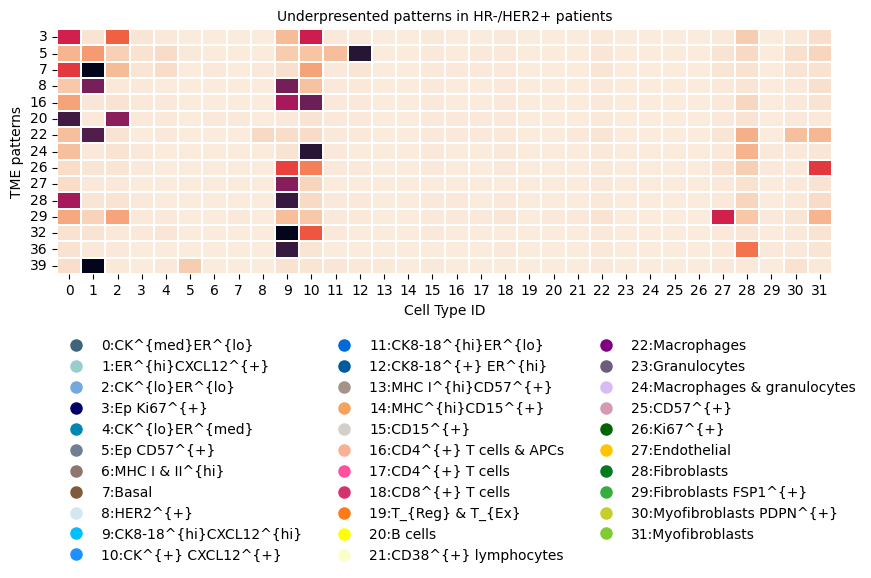

In [73]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
Centroids = compute_cluster_centroids(X, Cluster_identities)
print(Centroids.shape)
if len(Overpresented_in_pos) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7),  gridspec_kw= {"height_ratios": [1,1]})
    sns.heatmap(
                Centroids[Overpresented_in_pos, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_pos], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Overpresented patterns in HR-/HER2+ patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()
if len(Overpresented_in_neg) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7),  gridspec_kw= {"height_ratios": [1,1]})
    sns.heatmap(
                Centroids[Overpresented_in_neg, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_neg], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Underpresented patterns in HR-/HER2+ patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()

# HR+/HER2+

### Over-presented patterns

In [74]:
from scipy import stats
Histogram_pos = Histograms[Clinical_subtype == 'HR+/HER2+']
Histogram_neg = Histograms[Clinical_subtype != 'HR+/HER2+']
Overpresented_in_pos = []
Overpresented_in_neg = []
for i in range(Histograms.shape[1]):
    rvsi = Histogram_pos[:, i]
    rvso = Histogram_neg[:, i]
    result = stats.ttest_ind(rvsi, rvso, equal_var=False)
    if result.pvalue < 0.05 / Histograms.shape[1]:
        print("Pattern {}, Mean in pos = {:.0f}, Mean in neg = {:.0f} (p={:.5f})".format(i, np.mean(rvsi), np.mean(rvso), result.pvalue))
        if np.mean(rvsi) > np.mean(rvso):
            Overpresented_in_pos.append(i)
        else:
            Overpresented_in_neg.append(i)
if len(Overpresented_in_pos) == 0:
    print("No pattern is overpresented in HR+/HER2+ patients")
if len(Overpresented_in_neg) == 0:
    print("No pattern is underpresented in HR+/HER2+ patients")


Pattern 2, Mean in pos = 9, Mean in neg = 81 (p=0.00000)
Pattern 4, Mean in pos = 4, Mean in neg = 74 (p=0.00000)
Pattern 6, Mean in pos = 11, Mean in neg = 67 (p=0.00000)
Pattern 7, Mean in pos = 5, Mean in neg = 64 (p=0.00000)
Pattern 11, Mean in pos = 6, Mean in neg = 58 (p=0.00000)
Pattern 15, Mean in pos = 1, Mean in neg = 50 (p=0.00000)
Pattern 23, Mean in pos = 3, Mean in neg = 35 (p=0.00002)
Pattern 27, Mean in pos = 3, Mean in neg = 29 (p=0.00000)
Pattern 28, Mean in pos = 13, Mean in neg = 27 (p=0.00012)
Pattern 31, Mean in pos = 1, Mean in neg = 25 (p=0.00000)
Pattern 35, Mean in pos = 3, Mean in neg = 18 (p=0.00048)
Pattern 37, Mean in pos = 1, Mean in neg = 17 (p=0.00000)
No pattern is overpresented in HR+/HER2+ patients


(64, 32)


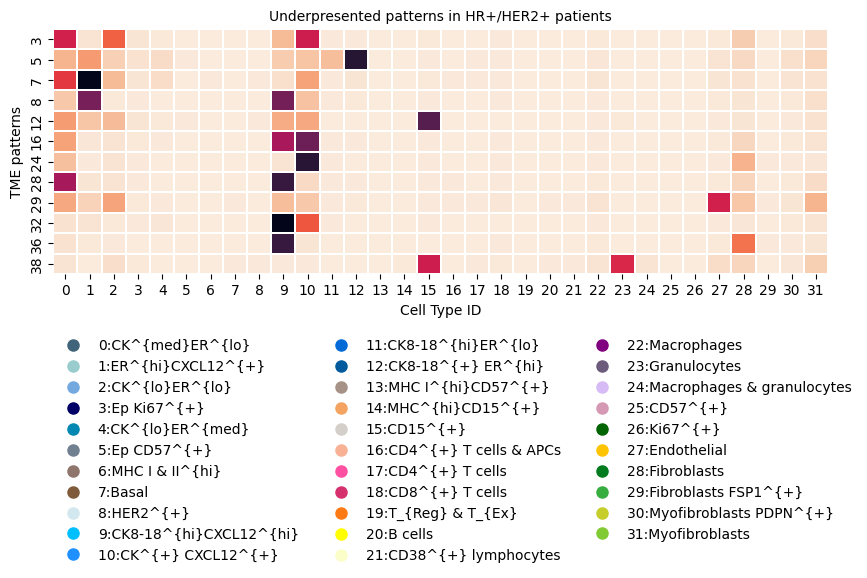

In [75]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
Centroids = compute_cluster_centroids(X, Cluster_identities)
print(Centroids.shape)
if len(Overpresented_in_pos) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7),  gridspec_kw= {"height_ratios": [1,1]})
    sns.heatmap(
                Centroids[Overpresented_in_pos, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_pos], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Overpresented patterns in HR+/HER2+ patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()
if len(Overpresented_in_neg) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7),  gridspec_kw= {"height_ratios": [1,1]})
    sns.heatmap(
                Centroids[Overpresented_in_neg, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_neg], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Underpresented patterns in HR+/HER2+ patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()